# Document Purpose:
* exploratory data analysis
* Baseline ML Model with Evaluation: PREDICT percent change in stock price after next earnings event for all company

# Imports

In [30]:
## data cleaning/analysis
import pandas as pd
import numpy as np
from scipy.stats import zscore

## Vizzes
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# modeling:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree, export_text
# conda install 
# import graphviz


In [10]:
data = pd.read_csv("data/exports/data_full.csv")

# dataset with only numeric columns, dates excluded 
# Remove AjClose and Adj Close Pct Change (no significant difference visually between the two)
data_num = data[['Close', 'Close_pct_change', 'premarket_pub',
       'EPS Estimate', 'Reported EPS', 'Surprise(%)']].copy()
data_num

Close  Close_pct_change  premarket_pub  EPS Estimate  Reported EPS  \
0      39.970001          0.034153              1          0.66          0.81   
1     110.970001         -0.014301              1          2.61          2.75   
2     161.860001          0.033325              1          1.18          1.65   
3      96.029999          0.097737              1          0.74          1.28   
4      77.029999         -0.054847              1          1.46          1.48   
...          ...               ...            ...           ...           ...   
5929   19.190001          0.061981              1         -0.13         -0.07   
5930   78.550003          0.051821              1          0.43          0.52   
5931   20.510000          0.068786              0         -0.15         -0.15   
5932  122.529999          0.009059              1          0.85          1.03   
5933  118.900002         -0.070077              1          1.07          1.08   

      Surprise(%)  
0          0.2193  
1          0.0551  
2          0.3983  
3          0.7231  
4          0.0126  
...           ...  
5929       0.4615  
5930       0.2178  
5931       0.0196  
5932       0.2175  
5933       0.0056  

[5934 rows x 6 columns]

In [11]:
data

date symbol                                     security_name  \
0     2023-01-05    CAG                 ConAgra Brands, Inc. Common Stock   
1     2023-01-05   HELE              Helen of Troy Limited - Common Stock   
2     2023-01-05    LNN                  Lindsay Corporation Common Stock   
3     2023-01-05     LW          Lamb Weston Holdings, Inc. Common Stock    
4     2023-01-05    MSM  MSC Industrial Direct Company, Inc. Common Stock   
...          ...    ...                                               ...   
5929  2023-12-21    CCL                 Carnival Corporation Common Stock   
5930  2023-12-21    KMX                                        CarMax Inc   
5931  2023-12-21   LMNR                       Limoneira Co - Common Stock   
5932  2023-12-21    NKE                           Nike, Inc. Common Stock   
5933  2023-12-21   PAYX                      Paychex, Inc. - Common Stock   

      premarket_pub before_eps_date after_eps_date   Adj Close       Close  \
0                 1      2023-01-04     2023-01-05   39.970001   39.970001   
1                 1      2023-01-04     2023-01-05  110.970001  110.970001   
2                 1      2023-01-04     2023-01-05  161.860001  161.860001   
3                 1      2023-01-04     2023-01-05   96.029999   96.029999   
4                 1      2023-01-04     2023-01-05   77.029999   77.029999   
...             ...             ...            ...         ...         ...   
5929              1      2023-12-20     2023-12-21   19.190001   19.190001   
5930              1      2023-12-20     2023-12-21   78.550003   78.550003   
5931              0      2023-12-21     2023-12-22   20.510000   20.510000   
5932              1      2023-12-20     2023-12-21  122.529999  122.529999   
5933              1      2023-12-20     2023-12-21  118.900002  118.900002   

      Adj Close_pct_change  Close_pct_change  EPS Estimate  Reported EPS  \
0                 0.034153          0.034153          0.66          0.81   
1                -0.014301         -0.014301          2.61          2.75   
2                 0.033325          0.033325          1.18          1.65   
3                 0.097737          0.097737          0.74          1.28   
4                -0.054847         -0.054847          1.46          1.48   
...                    ...               ...           ...           ...   
5929              0.061981          0.061981         -0.13         -0.07   
5930              0.051821          0.051821          0.43          0.52   
5931              0.068786          0.068786         -0.15         -0.15   
5932              0.009059          0.009059          0.85          1.03   
5933             -0.070077         -0.070077          1.07          1.08   

      Surprise(%)  premarket  
0          0.2193        1.0  
1          0.0551        1.0  
2          0.3983        1.0  
3          0.7231        1.0  
4          0.0126        1.0  
...           ...        ...  
5929       0.4615        1.0  
5930       0.2178        1.0  
5931       0.0196        NaN  
5932       0.2175        1.0  
5933       0.0056        1.0  

[5934 rows x 14 columns]

# Cleaning

### outliers detection:

In [12]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data_num[((data_num < lower_bound) | (data_num > upper_bound)).any(axis=1)]

print("Outliers:")
outliers

Outliers:


Close  Close_pct_change  premarket_pub  EPS Estimate  Reported EPS  \
2     161.860001          0.033325              1          1.18          1.65   
3      96.029999          0.097737              1          0.74          1.28   
6       2.170000          0.043269              0         -0.06         -0.28   
7     174.649994          0.028805              1          3.01          3.29   
10      9.480000          0.045204              0          0.11          0.30   
...          ...               ...            ...           ...           ...   
5918  149.279999         -0.035721              0          4.59          4.82   
5920   41.480000          0.036223              1          2.65          2.45   
5921  162.490005         -0.003679              1          1.74          1.84   
5922  341.510010         -0.000995              1          3.14          3.27   
5925    4.100000         -0.026128              1         -0.03          0.01   

      Surprise(%)  
2          0.3983  
3          0.7231  
6         -3.4213  
7          0.0947  
10         1.8571  
...           ...  
5918       0.0494  
5920      -0.0755  
5921       0.0605  
5922       0.0401  
5925       1.3704  

[2188 rows x 6 columns]

In [13]:
# Drop outliers
df_no_out = data_num.drop(outliers.index).reset_index(drop=True)

print("DataFrame after dropping outliers:")
df_no_out

DataFrame after dropping outliers:


Close  Close_pct_change  premarket_pub  EPS Estimate  Reported EPS  \
0      39.970001          0.034153              1          0.66          0.81   
1     110.970001         -0.014301              1          2.61          2.75   
2      77.029999         -0.054847              1          1.46          1.48   
3      85.169998         -0.131096              1          1.10          1.10   
4      45.000000          0.066098              0          0.79          0.88   
...          ...               ...            ...           ...           ...   
3741   19.190001          0.061981              1         -0.13         -0.07   
3742   78.550003          0.051821              1          0.43          0.52   
3743   20.510000          0.068786              0         -0.15         -0.15   
3744  122.529999          0.009059              1          0.85          1.03   
3745  118.900002         -0.070077              1          1.07          1.08   

      Surprise(%)  
0          0.2193  
1          0.0551  
2          0.0126  
3         -0.0026  
4          0.1186  
...           ...  
3741       0.4615  
3742       0.2178  
3743       0.0196  
3744       0.2175  
3745       0.0056  

[3746 rows x 6 columns]

### Missing Values

In [14]:
missing_val = df_no_out[["Close","Close_pct_change", "EPS Estimate","Reported EPS"]].copy()
index_to_drop = missing_val.loc[missing_val.isna().any(axis = 1), :].index

# leaving Surprise NaN's for EDA

In [15]:
# drop rows with missing values 
df_clean = df_no_out.drop(index_to_drop).reset_index(drop = True).copy()

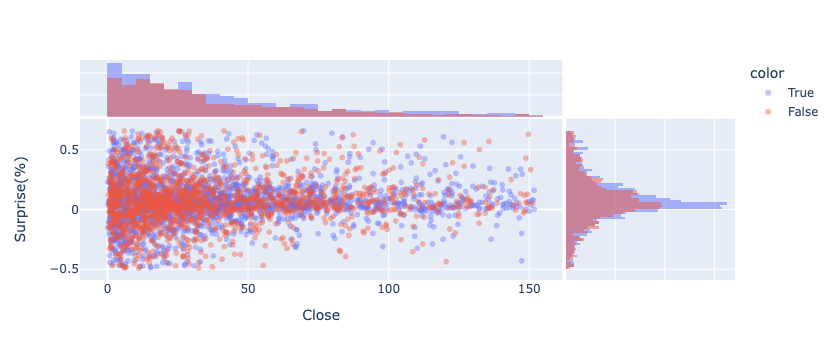

In [25]:
# plot reported EPS and EPS estimate, add close value of stock price as hue
# x and y given as array_like objects
import plotly.express as px
x_vals = df_clean['EPS Estimate']
y_vals = df_clean['Reported EPS']

# fig = px.scatter(x=x_vals, y=y_vals)


fig = px.scatter(df_clean, x="Close", y="Surprise(%)", color=df_clean["premarket_pub"].astype('bool'), opacity = .4, marginal_x="histogram", marginal_y="histogram")
fig.show()

# EDA

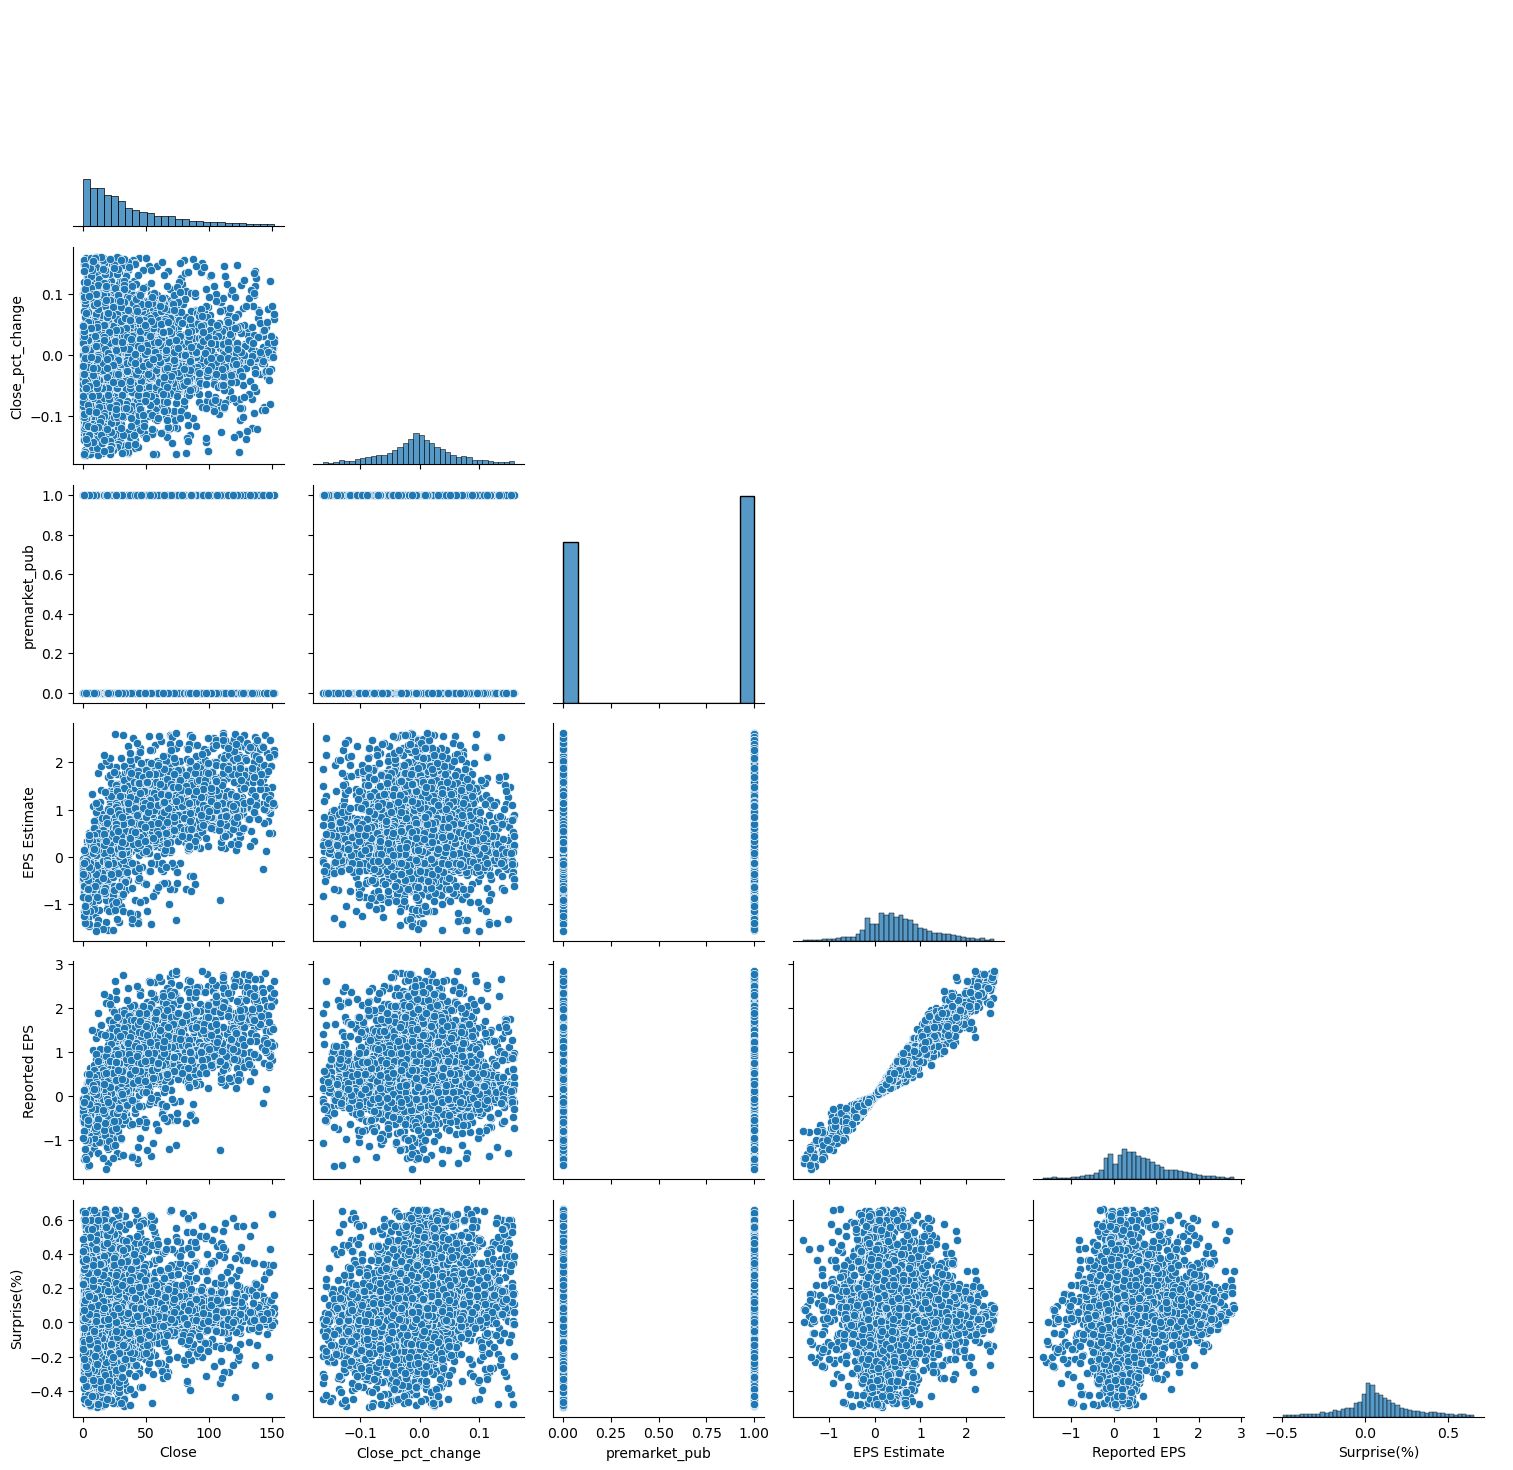

In [26]:
g = sns.PairGrid(df_clean,corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

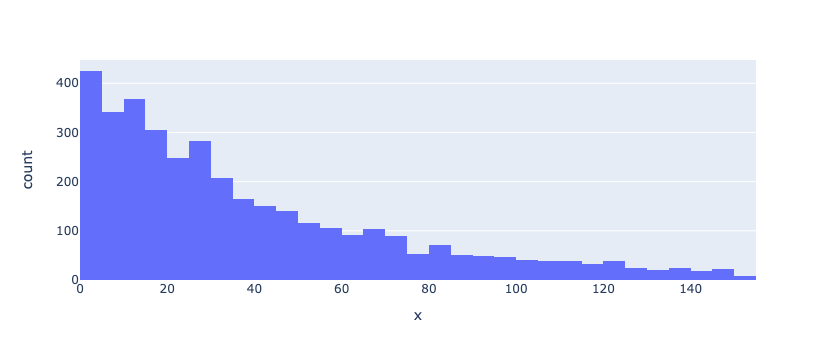

In [27]:
# Create histogram
fig = px.histogram(x=df_clean['Close'])

# Show plot
fig.show()

# remove outliers

<Axes: >

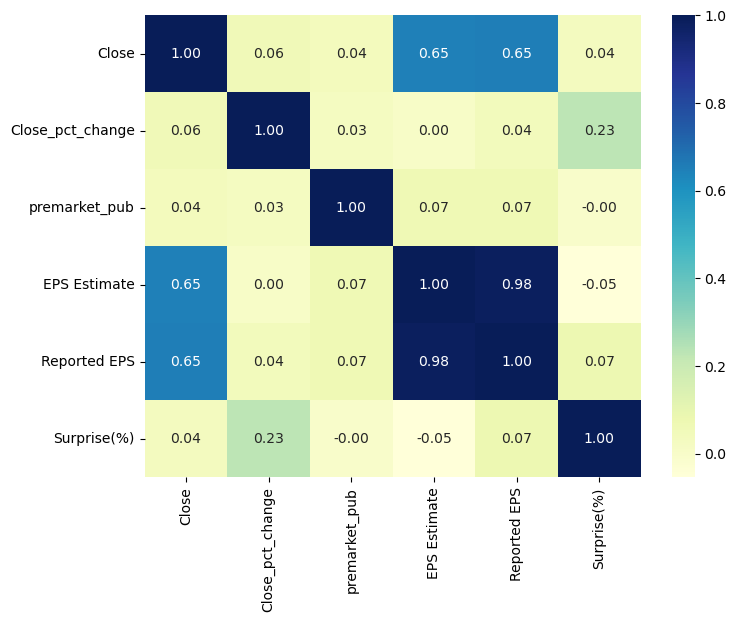

In [28]:
# correlation matrix outliers removed: 
plt.figure(figsize=(8, 6))
corr_matrix = df_clean.corr(numeric_only=True)


sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 10})


# Modelling

### Stock Price and Percent Change after Earnings Event
Project goal was specifically to develop a model that predicted the percent change of and Earnings Event based on the the stock price. 

The scatter plot below shows the relationship between closing stock price and the percent change. 

From the correlation heat map above, the correlation coefficient (CC) between closing stock price and percent change in stock price after earnings event is **0.04**. 
Correlation coefficients values ranges from -1 to 1, where:

* 1 indicates a perfect positive linear relationship,
* -1 indicates a perfect negative linear relationship, and
* 0 indicates no linear relationship between the variables.

As a result of the CC, the model may struggle to make reliable or useful predictions. 

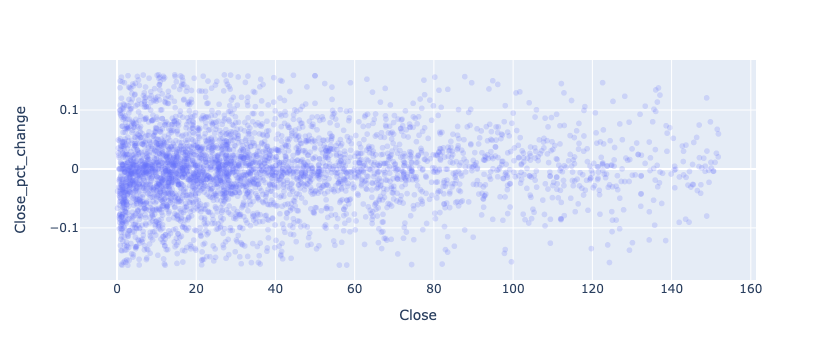

In [29]:

import plotly.express as px

fig = px.scatter(df_clean, x="Close", y="Close_pct_change", opacity = .2)
fig.show()

## Baseline Statistical Model
(no predicitons)

Null hypothesis:
There is no relationship between the **closing stocks percent change** and **reported earnings per share**

Alternative hypothesis:
There is a relationship between the **closing stocks percent change** and **reported earnings per share**

In [56]:
df_clean

Close  Close_pct_change  premarket_pub  EPS Estimate  Reported EPS  \
0      39.970001          0.034153              1          0.66          0.81   
1     110.970001         -0.014301              1          2.61          2.75   
2      77.029999         -0.054847              1          1.46          1.48   
3      85.169998         -0.131096              1          1.10          1.10   
4      45.000000          0.066098              0          0.79          0.88   
...          ...               ...            ...           ...           ...   
3712   19.190001          0.061981              1         -0.13         -0.07   
3713   78.550003          0.051821              1          0.43          0.52   
3714   20.510000          0.068786              0         -0.15         -0.15   
3715  122.529999          0.009059              1          0.85          1.03   
3716  118.900002         -0.070077              1          1.07          1.08   

      Surprise(%)  
0          0.2193  
1          0.0551  
2          0.0126  
3         -0.0026  
4          0.1186  
...           ...  
3712       0.4615  
3713       0.2178  
3714       0.0196  
3715       0.2175  
3716       0.0056  

[3717 rows x 6 columns]

In [79]:
# split target (what we are trying to predict, Y) and features (independent variables, X)
y = df_clean['Close_pct_change'].copy()
X = df_clean[['Close', 'Reported EPS', 'premarket_pub']].copy() # not including surprise since it is calculated using EPS Estimate and Reported EPS


In [80]:
# simple linear regression 
# X single value values (close)
X_simple = X['Reported EPS'] 
mod = sm.OLS(y, X_simple)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:       Close_pct_change   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2850
Date:                Fri, 15 Mar 2024   Prob (F-statistic):                       0.593
Time:                        10:48:51   Log-Likelihood:                          5106.0
No. Observations:                3717   AIC:                                 -1.021e+04
Df Residuals:                    3716   BIC:                                 -1.020e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Interpretation:
Based on this statistical model,

* the Reported EPS pvalue of 0.593 is greater than the threshold of 0.05. There is insufficient evidence to reject the status quo/default assumption/null hypothesis“
The null hypothesis is upheld: There is no relationship between the **closing stocks percent change** and **reported earnings per share**
* The R-Square value of 0.00 means that the input variables explain 0% of the patterns in the target variable (the stock price percentage change)



In [81]:
# MULTI linear regression 
# X single value values (close)
X_multi = X[['Close', 'Reported EPS', 'premarket_pub']]
mod = sm.OLS(y, X_multi)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:       Close_pct_change   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.6799
Date:                Fri, 15 Mar 2024   Prob (F-statistic):                       0.564
Time:                        10:48:53   Log-Likelihood:                          5106.8
No. Observations:                3717   AIC:                                 -1.021e+04
Df Residuals:                    3714   BIC:                                 -1.019e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## Baseline: Linear Regression

Develop a baseline linear regression model that predicts percent change in stock price based on Closing stock price, EPS Estimate and Reported EPS

In [82]:
# shuffle : 
X, y = shuffle(X, y, random_state = 27)
# set train ratio (percent of data to split)
train_ratio = 0.7

In [83]:
# make train and evaluate (test) split:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, shuffle = False, train_size = train_ratio)

print(f'{len(X_train)} training samples and {len(X_eval)} evaluation(test) samples')

2601 training samples and 1116 evaluation(test) samples


In [84]:
# train model with training set for X, and Y
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression()

In [85]:
## Evaluate performance of the model : 
y_train_pred = reg.predict(X_train)
y_eval_pred = reg.predict(X_eval)

r2_train = r2_score(y_train, y_train_pred)
r2_eval = r2_score(y_eval, y_eval_pred)

print(f'Train R^2:\t {r2_train}\nEval R^2:\t {r2_eval}')

Train R^2:	 0.0037166724265641493
Eval R^2:	 0.0012237267694326093


Proportion of the variation in dependent variable Y, that can be explained by independent variables. 
low only 0.001%. Model is overfit to training data, since it performs worse on new unseen (eval) data. 

In [87]:
# Mean Absolute Error:

LR_MAE_train = mean_absolute_error(y_train, y_train_pred) 
LR_MAE_eval = mean_absolute_error(y_eval, y_eval_pred) 

print(f'MAE Train:\t {LR_MAE_train}\nMAE Eval:\t {LR_MAE_eval}')


MAE Train:	 0.0457016687117951
MAE Eval:	 0.04833222209845915


This metric shows that the model performed slighthly better on unseen data. But values are still similar. MAE indicatest that on average, predictions are off by 0.048. 

In [88]:
# X_train
# X_eval

# y_train
y_eval
# y_eval_pred
# y_train_pred

2073   -0.053896
3131   -0.091897
2806    0.020600
1019    0.041365
2513    0.021524
          ...   
3096    0.112840
1317    0.031100
752    -0.129630
2591    0.018824
1043   -0.004043
Name: Close_pct_change, Length: 1116, dtype: float64

In [89]:
y_eval_pred = pd.DataFrame(y_eval_pred, columns = ['y_eval_pred_pct_stock_change'])

In [90]:
# y_eval
# type(y_eval)
y_eval = pd.DataFrame(y_eval).reset_index(drop=True)


In [91]:
y_eval

Close_pct_change
0            -0.053896
1            -0.091897
2             0.020600
3             0.041365
4             0.021524
...                ...
1111          0.112840
1112          0.031100
1113         -0.129630
1114          0.018824
1115         -0.004043

[1116 rows x 1 columns]

In [92]:
X_eval = X_eval.reset_index(drop = True).copy()

In [93]:
# type(X_eval)
type(y_eval_pred)
# y_eval_pred = pd.Series(y_eval_pred, name = 'y_eval_pred')
y_eval_pred

y_eval_pred_pct_stock_change
0                         0.000983
1                        -0.003347
2                        -0.001399
3                        -0.005970
4                        -0.004497
...                            ...
1111                     -0.005673
1112                      0.000059
1113                     -0.004105
1114                     -0.003558
1115                     -0.003967

[1116 rows x 1 columns]

In [94]:
eval = pd.concat([X_eval, y_eval, y_eval_pred], axis = 1)
eval

Close  Reported EPS  premarket_pub  Close_pct_change  \
0     66.180000          2.10              1         -0.053896   
1     35.080002          0.49              0         -0.091897   
2     40.130001          1.55              1          0.020600   
3     10.070000          0.38              0          0.041365   
4     23.730000          0.39              0          0.021524   
...         ...           ...            ...               ...   
1111   8.580000         -0.19              0          0.112840   
1112  47.410000          0.72              1          0.031100   
1113   1.880000         -0.24              1         -0.129630   
1114   4.330000         -0.59              1          0.018824   
1115   7.390000          0.33              1         -0.004043   

      y_eval_pred_pct_stock_change  
0                         0.000983  
1                        -0.003347  
2                        -0.001399  
3                        -0.005970  
4                        -0.004497  
...                            ...  
1111                     -0.005673  
1112                      0.000059  
1113                     -0.004105  
1114                     -0.003558  
1115                     -0.003967  

[1116 rows x 5 columns]

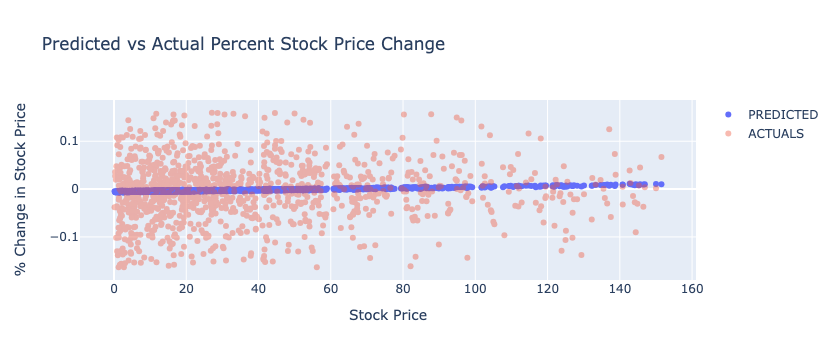

In [95]:
# visualise the predicted values against the actual values
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=eval['Close'], y=eval['y_eval_pred_pct_stock_change'], 
                    mode='markers',
                    name='PREDICTED', ))
fig.add_trace(go.Scatter(x=eval['Close'], y=eval['Close_pct_change'],opacity = 0.4,
                    mode='markers',
                    name='ACTUALS'))
fig.update_layout(
    title="Predicted vs Actual Percent Stock Price Change",
    xaxis_title="Stock Price",
    yaxis_title="% Change in Stock Price")

fig.show()

## Regression Tree

Attempt making prediction using regression tree instead. Known for being able to make predictions for non-linear data. 

In [96]:
feature = X.columns.tolist()
feature

['Close', 'Reported EPS', 'premarket_pub']

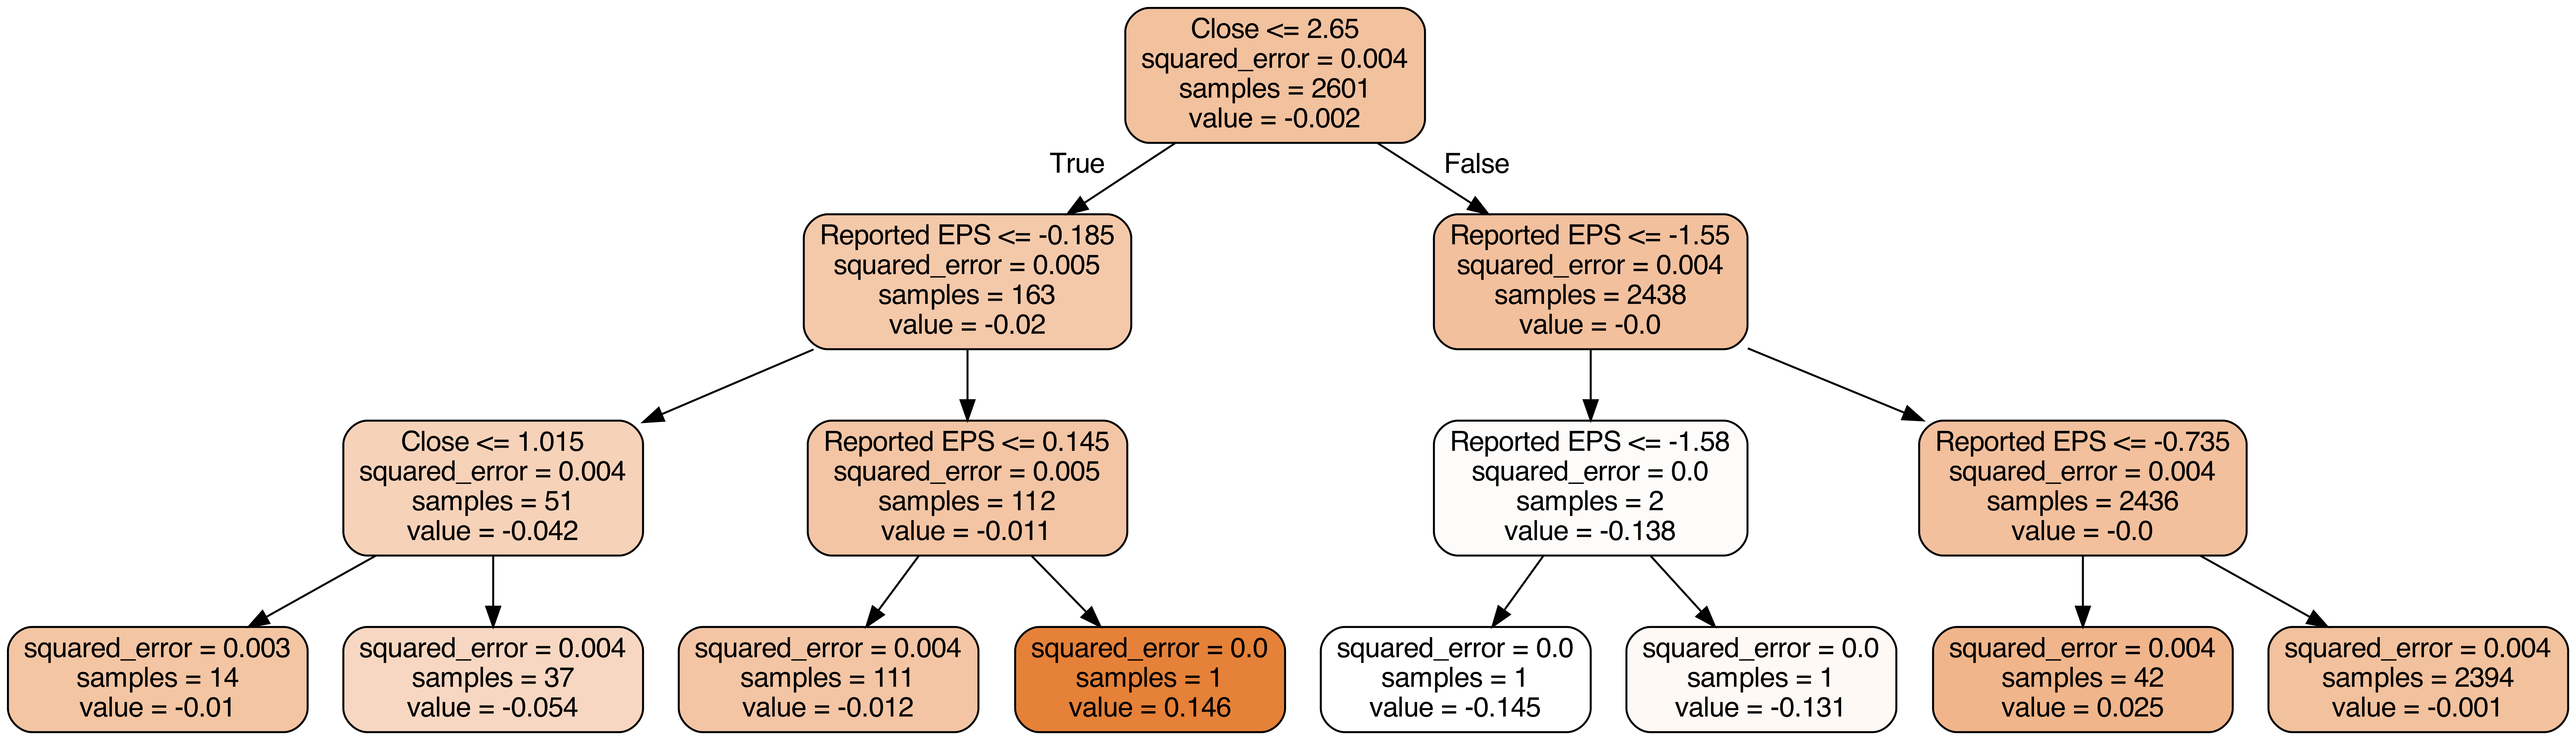

In [98]:
import graphviz
# train decision Tree regressor
dt = DecisionTreeRegressor(max_depth = 3)
model = dt.fit(X_train,y_train)


# view decision Tree
graphviz.Source(export_graphviz(model,
                                out_file='tree.dot',
                                feature_names=feature, rounded = True, proportion = False, 
                precision = 3, filled = True))

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=700'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [99]:
print(export_text(dt, feature_names = feature,  show_weights=True))

|--- Close <= 2.65
|   |--- Reported EPS <= -0.19
|   |   |--- Close <= 1.01
|   |   |   |--- value: [-0.01]
|   |   |--- Close >  1.01
|   |   |   |--- value: [-0.05]
|   |--- Reported EPS >  -0.19
|   |   |--- Reported EPS <= 0.15
|   |   |   |--- value: [-0.01]
|   |   |--- Reported EPS >  0.15
|   |   |   |--- value: [0.15]
|--- Close >  2.65
|   |--- Reported EPS <= -1.55
|   |   |--- Reported EPS <= -1.58
|   |   |   |--- value: [-0.15]
|   |   |--- Reported EPS >  -1.58
|   |   |   |--- value: [-0.13]
|   |--- Reported EPS >  -1.55
|   |   |--- Reported EPS <= -0.74
|   |   |   |--- value: [0.02]
|   |   |--- Reported EPS >  -0.74
|   |   |   |--- value: [-0.00]



In [100]:
y_eval_pred = model.predict(X_eval)

In [101]:
### EVAL (test)
mae_eval  = mean_absolute_error(y_eval, y_eval_pred)
mae_eval

print(f'Regression Tree: The mean absolute error for the evaluation data set is {mae_eval.round(4)}')

Regression Tree: The mean absolute error for the evaluation data set is 0.0485


In [102]:
## get MAE for TRAIN data set 
y_train_pred = model.predict(X_train)

### EVAL (test)
mae_train  = mean_absolute_error(y_train, y_train_pred)
mae_train

print(f'Regression Tree: The mean absolute error for the evaluation data set is {mae_train.round(4)}')

Regression Tree: The mean absolute error for the evaluation data set is 0.0453


In [103]:
y_train_pred = pd.Series(y_train_pred, name = 'y_train_pred_pct_change')
y_train_pred

0      -0.000811
1      -0.000811
2      -0.000811
3      -0.000811
4      -0.000811
          ...   
2596   -0.000811
2597   -0.000811
2598   -0.000811
2599   -0.000811
2600   -0.000811
Name: y_train_pred_pct_change, Length: 2601, dtype: float64

In [111]:
print(f'type for X_eval: {type(X_eval)})')
print(f'type for y_eval: {type(y_eval)})')
print(f'type for y_eval_pred: {type(y_eval_pred)}')


results_eval = pd.concat([X_eval, y_eval, pd.DataFrame(y_eval_pred, columns = ['y_eval_pred_pct_change'])], axis = 1)
results_eval

type for X_eval: <class 'pandas.core.frame.DataFrame'>)
type for y_eval: <class 'pandas.core.frame.DataFrame'>)
type for y_eval_pred: <class 'numpy.ndarray'>


Close  Reported EPS  premarket_pub  Close_pct_change  \
0     66.180000          2.10              1         -0.053896   
1     35.080002          0.49              0         -0.091897   
2     40.130001          1.55              1          0.020600   
3     10.070000          0.38              0          0.041365   
4     23.730000          0.39              0          0.021524   
...         ...           ...            ...               ...   
1111   8.580000         -0.19              0          0.112840   
1112  47.410000          0.72              1          0.031100   
1113   1.880000         -0.24              1         -0.129630   
1114   4.330000         -0.59              1          0.018824   
1115   7.390000          0.33              1         -0.004043   

      y_eval_pred_pct_change  
0                  -0.000811  
1                  -0.000811  
2                  -0.000811  
3                  -0.000811  
4                  -0.000811  
...                      ...  
1111               -0.000811  
1112               -0.000811  
1113               -0.053538  
1114               -0.000811  
1115               -0.000811  

[1116 rows x 5 columns]

In [112]:
type(y_train_pred)

pandas.core.series.Series

In [113]:
results_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), y_train_pred.reset_index(drop=True)], axis = 1)
results_train

Close  Reported EPS  premarket_pub  Close_pct_change  \
0      16.010000          0.18              0         -0.071346   
1      41.990002          1.33              0         -0.020984   
2      37.639999          0.38              1          0.004537   
3       8.600000          0.23              0         -0.016018   
4     101.400002          1.39              0          0.018686   
...          ...           ...            ...               ...   
2596   43.250000          1.16              1          0.038914   
2597    7.099000         -0.17              0         -0.078052   
2598   19.610001         -0.25              0          0.003069   
2599   45.240002          0.39              1         -0.123426   
2600   65.940002          1.49              1         -0.066138   

      y_train_pred_pct_change  
0                   -0.000811  
1                   -0.000811  
2                   -0.000811  
3                   -0.000811  
4                   -0.000811  
...                       ...  
2596                -0.000811  
2597                -0.000811  
2598                -0.000811  
2599                -0.000811  
2600                -0.000811  

[2601 rows x 5 columns]

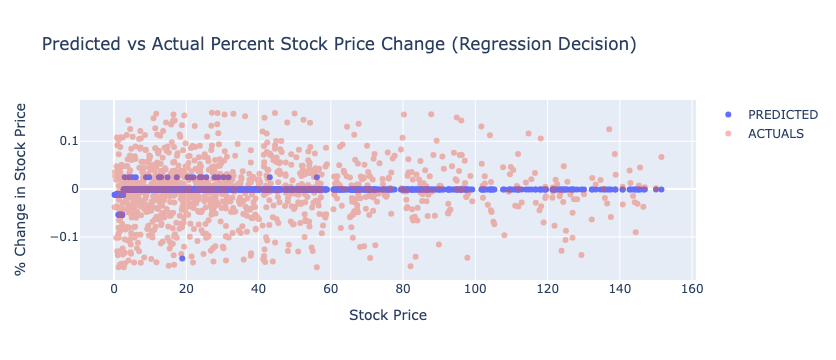

In [115]:
fig = go.Figure()
# fig = px.scatter(eval, x='Close', y='y_eval_pred', opacity = .2) 

# Add traces
fig.add_trace(go.Scatter(x=results_eval['Close'], y=results_eval['y_eval_pred_pct_change'], 
                    mode='markers',
                    name='PREDICTED', ))
fig.add_trace(go.Scatter(x=results_eval['Close'], y=results_eval['Close_pct_change'],opacity = 0.4,
                    mode='markers',
                    name='ACTUALS'))
fig.update_layout(
    title="Predicted vs Actual Percent Stock Price Change (Regression Decision)",
    xaxis_title="Stock Price",
    yaxis_title="% Change in Stock Price")

fig.show()

In [116]:
# export decision tree results to csv 
results_eval.to_csv('predictions/evaluation_data_predictions.csv', index = False)

## Interpretation : 
MAE for train and eval are almost identical between linear regression and decision tree regression. 

In [117]:
mae_dict = {'DTree': [mae_train, mae_eval],
           'LinearReg':[LR_MAE_train, LR_MAE_eval]}
mae_dict

{'DTree': [0.045341335508965706, 0.0484706371698529],
 'LinearReg': [0.0457016687117951, 0.04833222209845915]}

In [118]:
mae_results = pd.DataFrame.from_dict(mae_dict, orient= 'index', columns = ['Train', 'Eval'])

In [119]:
mae_results

Train      Eval
DTree      0.045341  0.048471
LinearReg  0.045702  0.048332

## Optimize Decision Tree

In [120]:
from sklearn.model_selection import GridSearchCV

In [121]:
parameters = {'max_depth': [2, 4, 6, 8], 'max_leaf_nodes': [3,4,6,8,10,12],
             'max_features': [1, 3, 4]}

In [122]:
dt1 = DecisionTreeRegressor()
dt1 = GridSearchCV(dt1, parameters)


In [123]:
dt1.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8], 'max_features': [1, 3, 4],
                         'max_leaf_nodes': [3, 4, 6, 8, 10, 12]})

In [124]:
dt1.best_params_

{'max_depth': 8, 'max_features': 1, 'max_leaf_nodes': 4}

In [125]:
y_predict_eval = dt1.predict(X_eval)
mae_eval_hp = mean_absolute_error(y_eval, y_predict_eval)
mae_eval_hp

0.04833222672267025

In [126]:
y_predict_train = dt1.predict(X_train)
mae_train_hp = mean_absolute_error(y_train, y_predict_train)
mae_train_hp

0.04542898815594508

In [127]:
mae_dict

{'DTree': [0.045341335508965706, 0.0484706371698529],
 'LinearReg': [0.0457016687117951, 0.04833222209845915]}

In [128]:
mae_results

Train      Eval
DTree      0.045341  0.048471
LinearReg  0.045702  0.048332

In [129]:
mae_results.loc['Dtree_tuned', :] = [mae_train_hp, mae_eval_hp]
mae_results

Train      Eval
DTree        0.045341  0.048471
LinearReg    0.045702  0.048332
Dtree_tuned  0.045429  0.048332

## Conclusion: 
* Results of all modelling are equal in performance.

In [130]:
mae_results.to_csv('predictions/mae_eval.csv')

# For future:

Thoughts for future and the next iteration of this model :
* look at other stock market features and find stronger linear relationships to use for predictions. Would there be an improvement to the performance of the model if incorporated:
    * premarket or postmarket announcement (as 1 for premarket, 0 for postmarket)
    * month announced
    * day of week announced
* integrate straddle returns into dataset
* Select highest priority stocks to evaluate and develop one one model per stock, integrating time series forecasting 
* 